In [129]:
import pathlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from skimage.feature import hog

In [130]:
# data_dir = pathlib.Path('./output/canny')
# data_dir = pathlib.Path('./output/canny_no_circle_det')
data_dir = pathlib.Path('./output/no_bg_fix_circle_mask_canny')
image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)

34


In [131]:
from sklearn.model_selection import train_test_split

rotation_aug = False

load_all_images = False

# resize_factor = 200
# resize_factor = 150
# resize_factor = 125
# resize_factor = 100
resize_factor = 50 # MPA, MP, DMMP
# resize_factor = 40
# resize_factor = 25
# resize_factor = 20
# resize_factor = 10
# resize_factor = 5

# Data selection
molecular_imprinting_name = 'DMMP'
# molecular_imprinting_name = 'MP'
# molecular_imprinting_name = 'MPA'

distraction_merge, distraction_merge_to_one, original_merge_to_one = False, False, False
# distraction_merge, distraction_merge_to_one, original_merge_to_one = False, True, False
# distraction_merge, distraction_merge_to_one, original_merge_to_one = True, False, False
# distraction_merge, distraction_merge_to_one, original_merge_to_one = False, False, True
# distraction_merge, distraction_merge_to_one, original_merge_to_one = False, True, True
# distraction_merge, distraction_merge_to_one, original_merge_to_one = True, False, True

x = []
y = []
resize_x = []
for path in data_dir.glob('*.jpg'):
    if not load_all_images:
        if path.name.split('-')[1] != molecular_imprinting_name and path.name.split('-')[1].split('(')[0] != molecular_imprinting_name:
            continue
    src = cv2.imread(str(path))
    src = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    height, width = src.shape[:2]
    center = (width / 2, height / 2)
    if rotation_aug:
        for i in range(3):
            rotation_matrix = rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=90 * i, scale=1)
            rotated_image = cv2.warpAffine(src=src, M=rotate_matrix, dsize=(width, height))
            resize_image = cv2.resize(src=rotated_image, dsize=(int(width / resize_factor), int(height / resize_factor)))
            resize_x.append(resize_image)
            resize_image = np.reshape(resize_image, (resize_image.shape[0] * resize_image.shape[1]))
            x.append(resize_image)
            if load_all_images:
                label_name = path.name.split('-')[1].split('(')[0] + '-' + path.name.split('-')[2].replace(' ', '')
                y.append(label_name)
            else:
                y.append(path.name.split('-')[2].replace(' ', ''))
    else:
        resize_image = cv2.resize(src=src, dsize=(int(width / resize_factor), int(height / resize_factor)))
        resize_x.append(resize_image)
        resize_image = np.reshape(resize_image, (resize_image.shape[0] * resize_image.shape[1]))
        x.append(resize_image)
        if load_all_images:
            label_name = path.name.split('-')[1].split('(')[0] + '-' + path.name.split('-')[2].replace(' ', '')
            if label_name.split('-')[0] != label_name.split('-')[1]:
                if distraction_merge or distraction_merge_to_one:
                    if distraction_merge_to_one:
                        label_name = 'distraction'
                    else:
                        label_name = label_name.split('-')[0] + '-distraction'
            elif label_name.split('-')[0] == label_name.split('-')[1]:
                if original_merge_to_one :
                    label_name = 'original'
        else:
            if distraction_merge or distraction_merge_to_one:
                if path.name.split('-')[2].split('(')[0] != molecular_imprinting_name:
                    if distraction_merge_to_one:
                        label_name = 'distraction'
                    else:
                        label_name = path.name.split('-')[1].split('(')[0] + '-distraction'
                else:
                    label_name = path.name.split('-')[2].replace(' ', '')
            else:
                label_name = path.name.split('-')[2].replace(' ', '')
        y.append(label_name)
x = np.array(x)
y = np.array(y)
resize_x = np.array(resize_x)
print('data loaded x=%i' % (len(x)))
print('data loaded y=%i' % (len(y)))

data loaded x=10
data loaded y=10


Granularity=(20, 20)


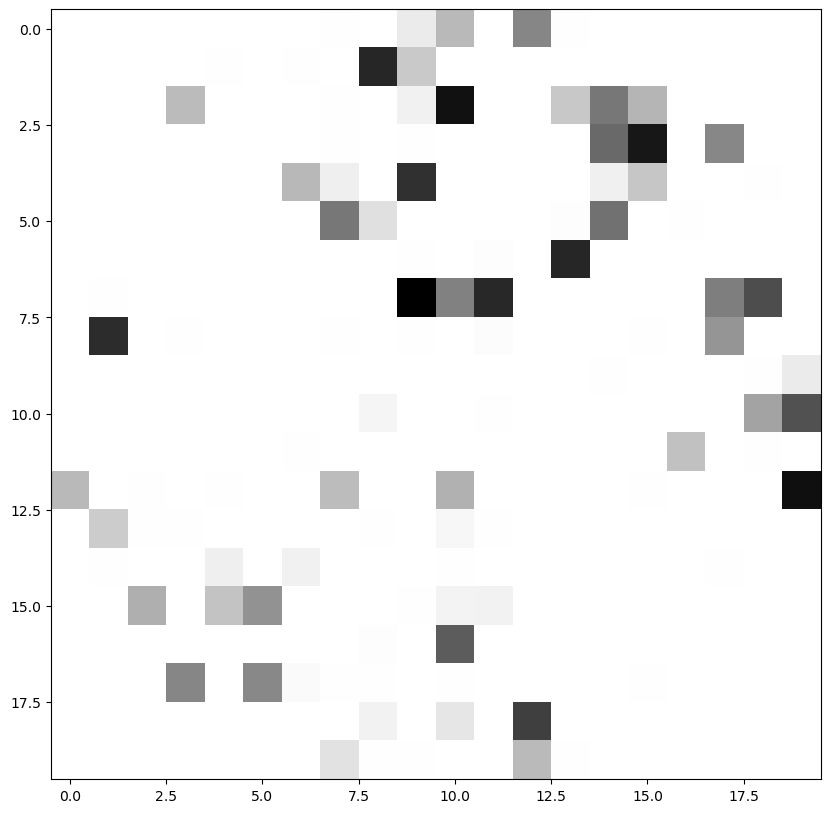

In [132]:
white_mask = np.ones(shape=resize_x[0].shape)
print('Granularity=%s' % str(resize_x[0].shape))
plt.figure(figsize=(10, 10))
plt.imshow(white_mask - resize_x[0], cmap='gray')

In [133]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = scaler.fit_transform(x)

In [134]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, stratify=y, random_state=1)
# print(x_train.shape)
# print(y_train)
# print(y_test)

DATA MINING

In [135]:
use_entire_dataset = True

from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler
perplexity=5
pca = TSNE(n_components=3, learning_rate='auto', init='pca', perplexity=perplexity)
if use_entire_dataset:
    x_train_pca = pca.fit_transform(x)
    y_train = y
else:
    x_train_pca = pca.fit_transform(x_train)
    y_train = y_train

x_train_pca

array([[  -2.1515176,   35.383354 ,  281.5092   ],
       [-120.97621  ,   25.119915 ,   94.50001  ],
       [ -96.307076 , -138.87294  ,   -4.450339 ],
       [  70.1916   , -235.09085  ,   23.399086 ],
       [  75.94104  ,  -95.57549  ,  -61.38202  ],
       [ -16.414705 ,  272.72726  ,   60.976498 ],
       [ 135.67648  ,   63.067448 ,   16.38823  ],
       [ -57.01101  , -110.3304   , -220.30032  ],
       [ -40.090935 ,  124.619514 ,  -45.31399  ],
       [ -30.582296 ,   -3.2286992,  -87.39163  ]], dtype=float32)

In [136]:
import pandas as pd

df = pd.DataFrame(x_train_pca, columns=[f"PC{i + 1}" for i in range(3)])
label_list = []

for i in range(len(x_train_pca)):
    label_list.append(y_train[i])

df['label'] = label_list
df

,PC1,PC2,PC3,label
0,-2.151518,35.383354,281.509186,NaBF4
1,-120.976212,25.119915,94.500008,NaBF4
2,-96.307076,-138.872940,-4.450339,NaBF4
3,70.191597,-235.090851,23.399086,DMMP
4,75.941040,-95.575493,-61.382019,DMMP
5,-16.414705,272.727264,60.976498,DMMP
6,135.676483,63.067448,16.388229,DMMP
7,-57.011009,-110.330399,-220.300323,KF6P
8,-40.090935,124.619514,-45.313992,KF6P
9,-30.582296,-3.228699,-87.391632,KF6P


In [137]:
# df = df.append({'PC1': 0.0, 'PC2': 0.0, 'PC3': 0.0, 'label': 'DMMP'}, ignore_index=True)

In [138]:
import plotly.io as pio

print(pio.templates)
pio.templates.default = 'plotly'

Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']



In [139]:
import plotly.express as px

fig = px.scatter_3d(df, x='PC1', y='PC2',z='PC3',  color='label', symbol='label', title='Canny TSNE %s Granularity=%s Sperplexity=%s' % (molecular_imprinting_name, str(resize_x[0].shape), str(perplexity)), color_discrete_map={
                "DMMP": "red",
                "NaBF4": "green",
                "KF6P": "blue",
                "MPA": "goldenrod",
                "MP": "purple"},
                symbol_sequence= ['circle', 'circle', 'circle', 'circle'],)
fig.update_layout(scene=dict(
    xaxis=dict(showticklabels=False),
    yaxis=dict(showticklabels=False),
    zaxis=dict(showticklabels=False)
))
fig.show()

Final Model

In [140]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

estimators = [('std', StandardScaler()), ('reduce_dim', PCA(n_components=3, svd_solver='full')), ('clf', SVC())]
pipe = Pipeline(estimators)
pipe.fit(x_train, y_train)
print(pipe.score(x_test, y_test))
print(classification_report(y_test, pipe.predict(x_test)))

NameError: name 'x_train' is not defined

In [ ]:
estimators = [('std', StandardScaler()), ('reduce_dim', PCA(n_components=4, svd_solver='full')), ('clf', KNeighborsClassifier(1))]
pipe = Pipeline(estimators)
pipe.fit(x_train, y_train)
print(pipe.score(x_test, y_test))
print(classification_report(y_test, pipe.predict(x_test)))

In [ ]:
best = (0, 0)
for i in range(1, 10):
    estimators = [('std', StandardScaler()), ('reduce_dim', PCA(n_components=i, svd_solver='full')), ('clf', KNeighborsClassifier(1))]
    pipe = Pipeline(estimators)
    pipe.fit(x_train, y_train)
    score = pipe.score(x_test, y_test)
    if score > best[1]:
        best = (i, score)
print(best)

In [ ]:
best = (0, 0)
for i in range(1, 10):
    estimators = [('std', StandardScaler()), ('reduce_dim', PCA(n_components=i, svd_solver='full')), ('clf', SVC())]
    pipe = Pipeline(estimators)
    pipe.fit(x_train, y_train)
    score = pipe.score(x_test, y_test)
    if score > best[1]:
        best = (i, score)

print(best)

In [ ]:
from matplotlib import cm
# Wrong classification visualization
import matplotlib.image as mpimg

predict_result = pipe.predict(x_test)
wrong_classification = []
wrong_classification_label = []
for i in range(len(predict_result)):
    if predict_result[i] != y_test[i]:
        wrong_classification.append(i)
        wrong_classification_label.append(y_test[i])
print(wrong_classification_label)
for i, path in enumerate(data_dir.glob('*.jpg')):
    if i in wrong_classification:
        img = cv2.imread(str(path))
        label = wrong_classification_label[wrong_classification.index(i)]
        # cv2.imshow(label, img)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

In [ ]:
# Reverse pattern with PCA
pca = PCA(n_components=3, svd_solver='full')
pca.fit(x_train)

guess_data = np.array([-4400, 5200, 120])
data_original = np.dot(guess_data, pca.components_)  # inverse_transform
data_original = np.reshape(data_original, (500, 500))

In [ ]:
plt.imshow(data_original, cmap='gray')